<h1>Elastic-Compute Process Notebook</h1>

Sean Keery, Rick Farmer, Robert Johnson

Understanding how better to do capacity planning and alerting for microservice-based, container-managed clusters of compute resources.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [20]:
inData=open('cf_nozzle_containerdata.js').read()
inDataSplit = inData.split(" ")
originList = [] 
eventTypeList = []
timestampList = []
deployList = []
jobList = []
indexList = []
ipList = []
appIDList = []
instanceList = []
cpuList = []
memoryList = []
diskList = []
for item in inDataSplit:
    if "origin" in item:
        origin = item.replace(">\r\n\r\norigin:","")
        originList.append(origin)
    if "eventType" in item:
        eventType = item.replace("eventType:","")
        eventTypeList.append(eventType)
    if "timestamp" in item:
        timestamp = int(item.replace("timestamp:",""))
        timestampList.append(timestamp)
    if "deployment" in item:
        deployment = item.replace("deployment:","")
        deployList.append(deployment)
    if 'job' in item:
        job = item.replace("job:","")
        jobList.append(job)
    if 'index' in item:
        index = item.replace("index:","")
        indexList.append(index)
    if 'ip' in item:
        ip = item.replace("ip:","")
        ipList.append(ip)
    if 'applicationId' in item:
        applicationId = item.replace("containerMetric:<applicationId:","")
        appIDList.append(applicationId)
    if 'instanceIndex' in item:
        instanceIndex = item.replace("instanceIndex:","")
        instanceList.append(instanceIndex)
    if 'cpuPercentage' in item:
        cpuPercentage = float(item.replace("cpuPercentage:",""))
        cpuList.append(cpuPercentage)
    if 'memoryBytes' in item:
        memoryBytes = int(item.replace("memoryBytes:",""))
        memoryList.append(memoryBytes)
    if 'diskBytes' in item:
        diskBytes = int(item.replace("diskBytes:",""))
        diskList.append(diskBytes)

#Handle Problematic first origin case
originList[0] = "rep"

dataDict = {"origin":originList,"event_type":eventTypeList,"timestamp":timestampList,"deployment":deployList,"job":jobList,
           "index": indexList,"ip_address":ipList,"applicationID":appIDList,"instance_index":instanceList,
           "cpu_percentage":cpuList,"memory_bytes":memoryList, "disk_bytes":diskList}

testDF = pd.DataFrame(dataDict)
testDF.head()

,applicationID,cpu_percentage,deployment,disk_bytes,event_type,index,instance_index,ip_address,job,memory_bytes,origin,timestamp
0,"""da31b47f-d681-47fc-995d-d373aec0913d""",0.028438,"""cf""",155435008,ContainerMetric,"""0""",0,"""10.0.16.24""","""diego_cell-partition-54b1951a8da59d4b5f49""",98910208,rep,1448303469569478632
1,"""82e3dd29-cedd-49ab-8a41-04d54c1b5dbd""",0.027995,"""cf""",68866048,ContainerMetric,"""0""",0,"""10.0.16.24""","""diego_cell-partition-54b1951a8da59d4b5f49""",14655488,"""rep""",1448303469569547297
2,"""42abb7c2-9a14-43a5-87d2-4ff9c17bf44d""",0.079901,"""cf""",184623104,ContainerMetric,"""0""",0,"""10.0.16.24""","""diego_cell-partition-54b1951a8da59d4b5f49""",205561856,"""rep""",1448303469569571750
3,"""e99fddfb-fa8b-4fd0-ac36-00f90718e952""",0.075975,"""cf""",184705024,ContainerMetric,"""0""",0,"""10.0.16.24""","""diego_cell-partition-54b1951a8da59d4b5f49""",296177664,"""rep""",1448303469569596309
4,"""d37a6942-6995-4b9b-9639-9b50386a33df""",0.276585,"""cf""",199929856,ContainerMetric,"""0""",1,"""10.0.16.24""","""diego_cell-partition-54b1951a8da59d4b5f49""",730755072,"""rep""",1448303469569616341


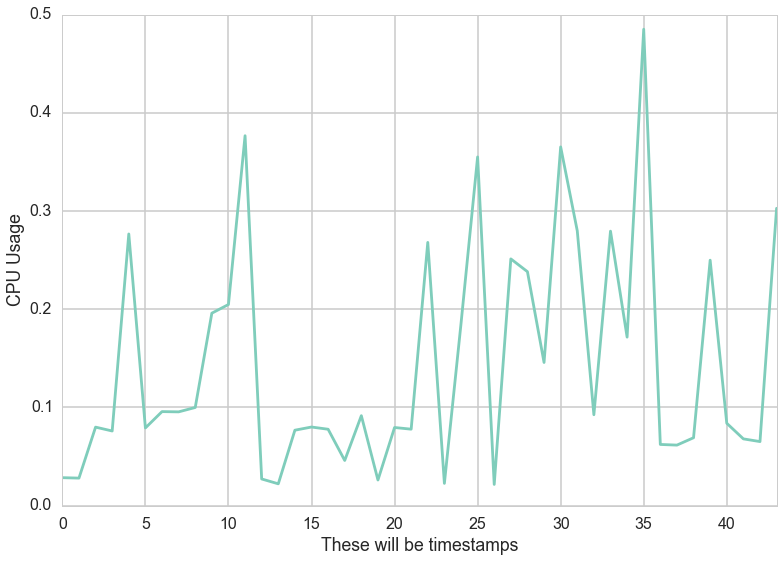

In [15]:
ax = sns.tsplot(testDF.cpu_percentage, color = "#7fcdbb")
ax.set_ylabel("CPU Usage")
ax.set_xlabel("These will be timestamps")

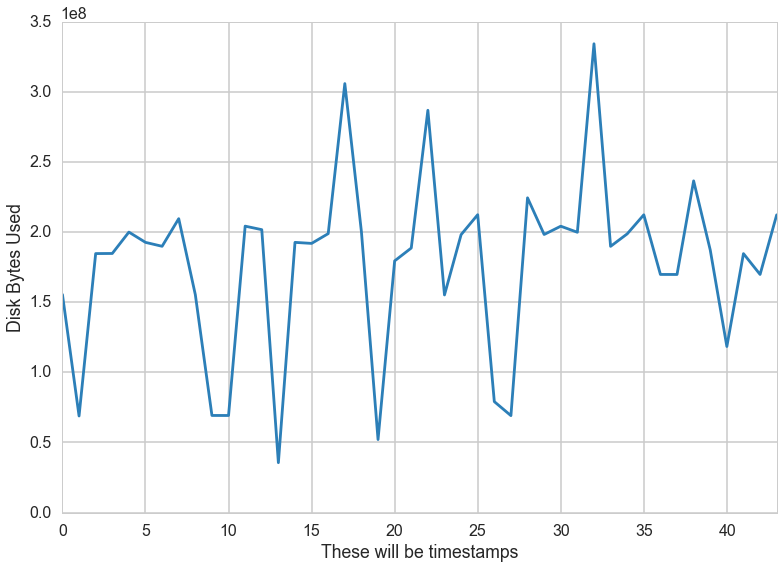

In [13]:
ax = sns.tsplot(testDF.disk_bytes, color = "#2c7fb8")
ax.set_ylabel("Disk Bytes Used")
ax.set_xlabel("These will be timestamps")

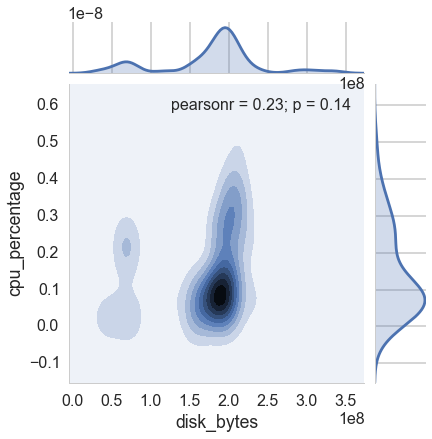

In [19]:
ax = sns.jointplot(testDF.disk_bytes,testDF.cpu_percentage, kind ='kde')